# Classifier Comparison: SVM vs CNN Architectures

Compare classification performance of different approaches on hyperspectral data:

1. **SVM with RBF kernel** - Spectral-only baseline
2. **1D-CNN** - Spectral feature learning
3. **2D-CNN** - Spatial feature extraction
4. **3D-CNN** - Joint spatial-spectral learning

Focus areas:
- Overall classification accuracy
- Edge-case pixel performance
- Training efficiency
- Effect of local similarity features

## 1. Setup

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time

# PyTorch
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'mps'

# Our modules
from src.data import preprocess_pipeline
from src.features import extract_patches, split_dataset
from src.models import (
    SVMClassifier, create_model,
    train_neural_network, create_data_loaders, TrainingConfig,
    compute_all_metrics, print_classification_report,
    batch_inference_cnn
)

# MLflow
import mlflow
mlflow.set_tracking_uri('mlruns')
mlflow.set_experiment('classifier_comparison')

np.random.seed(42)
torch.manual_seed(42)

print("✓ Setup complete!")

PyTorch version: 2.10.0
CUDA available: False
✓ Setup complete!


/Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:184: FutureWarning: The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.
  return FileStore(store_uri, store_uri)


## 2. Load Data

In [3]:
USE_REAL_DATA = True  # Set to True if Indian Pines is downloaded

project_root = Path.cwd().parent 

# Construct the absolute path to the data
DATA_DIR = project_root / 'data' / 'external' / 'indian_pines'

if USE_REAL_DATA:
    from src.data import load_benchmark_dataset
    # Pass the absolute path instead of a relative string
    cube = load_benchmark_dataset('indian_pines', DATA_DIR)
    hsi_data = cube.data
    ground_truth = cube.ground_truth
    class_names = cube.class_names
else:
    # Generate realistic synthetic data
    print("Generating synthetic HSI data...")
    
    height, width, n_bands = 80, 80, 150
    n_classes = 6
    
    # Create class-specific spectral signatures
    wavelengths = np.linspace(400, 2500, n_bands)
    class_spectra = np.zeros((n_classes, n_bands))
    for c in range(n_classes):
        peak_pos = 500 + c * 350
        class_spectra[c] = np.exp(-((wavelengths - peak_pos) ** 2) / (250 ** 2))
        class_spectra[c] += 0.25 * np.exp(-((wavelengths - (1600 + c * 80)) ** 2) / (120 ** 2))
    
    # Generate ground truth with spatial structure
    ground_truth = np.zeros((height, width), dtype=np.int32)
    for c in range(1, n_classes):
        for _ in range(np.random.randint(3, 7)):
            cr, cc = np.random.randint(8, height - 8), np.random.randint(8, width - 8)
            radius = np.random.randint(4, 12)
            for r in range(max(0, cr - radius), min(height, cr + radius)):
                for col in range(max(0, cc - radius), min(width, cc + radius)):
                    if ((r - cr) ** 2 + (col - cc) ** 2) < radius ** 2:
                        ground_truth[r, col] = c
    
    # Generate HSI cube
    hsi_data = np.zeros((height, width, n_bands), dtype=np.float32)
    for c in range(n_classes):
        mask = ground_truth == c
        n_px = np.sum(mask)
        if n_px > 0:
            hsi_data[mask] = class_spectra[c if c > 0 else 1] + 0.12 * np.random.randn(n_px, n_bands)
    
    class_names = ['Background'] + [f'Class_{c}' for c in range(1, n_classes)]

print(f"Data shape: {hsi_data.shape}")
print(f"Labeled samples: {np.sum(ground_truth > 0)}")

/Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/data/external/indian_pines/Indian_pines_corrected.mat
Filepath : /Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/data/external/indian_pines/Indian_pines_corrected.mat
Data shape: (145, 145, 200)
Labeled samples: 10249


In [4]:
# Preprocess
result = preprocess_pipeline(
    hsi_data,
    remove_water=False,
    reduce_dims='pca',
    n_components=30,
    normalize='minmax',
    log_to_mlflow=False
)
processed_data = result['data']
print(f"Preprocessed shape: {processed_data.shape}")

Preprocessed shape: (145, 145, 30)


In [6]:
# Extract patches
PATCH_SIZE = 5

dataset = extract_patches(
    processed_data,
    ground_truth,
    window_size=PATCH_SIZE,
    include_background=False,
    log_to_mlflow=False
)

# Split
train_set, val_set, test_set = split_dataset(
    dataset,
    train_ratio=0.15,
    val_ratio=0.1,
    test_ratio=0.75,
    stratify=True,
    log_to_mlflow=False
)

n_bands = processed_data.shape[-1]
n_classes = len(np.unique(train_set.labels))

print(f"Train: {train_set.n_samples}")
print(f"Val: {val_set.n_samples}")
print(f"Test: {test_set.n_samples}")
print(f"Bands: {n_bands}, Classes: {n_classes}")

Train: 1537
Val: 1024
Test: 7688
Bands: 30, Classes: 16


## 3. Edge Pixel Detection

In [7]:
from scipy.ndimage import sobel

# Detect edge pixels
edge_x = sobel(ground_truth.astype(float), axis=0)
edge_y = sobel(ground_truth.astype(float), axis=1)
edge_magnitude = np.sqrt(edge_x**2 + edge_y**2)

edge_mask = (edge_magnitude > 0) & (ground_truth > 0)
interior_mask = (edge_magnitude == 0) & (ground_truth > 0)

# Get masks for test set
test_positions = test_set.positions
test_edge_mask = np.array([edge_mask[r, c] for r, c in test_positions])
test_interior_mask = np.array([interior_mask[r, c] for r, c in test_positions])

print(f"Test edge pixels: {np.sum(test_edge_mask)} ({100*np.mean(test_edge_mask):.1f}%)")
print(f"Test interior pixels: {np.sum(test_interior_mask)} ({100*np.mean(test_interior_mask):.1f}%)")

Test edge pixels: 1976 (25.7%)
Test interior pixels: 5712 (74.3%)


## 4. Train and Evaluate Classifiers

In [8]:
def evaluate_classifier(y_true, y_pred, edge_mask, interior_mask, name):
    """Compute and display evaluation metrics."""
    metrics = compute_all_metrics(y_true, y_pred)
    
    edge_acc = np.mean(y_pred[edge_mask] == y_true[edge_mask]) if np.sum(edge_mask) > 0 else 0
    interior_acc = np.mean(y_pred[interior_mask] == y_true[interior_mask]) if np.sum(interior_mask) > 0 else 0
    
    return {
        'Model': name,
        'OA': metrics['overall_accuracy'],
        'AA': metrics['average_accuracy'],
        'Kappa': metrics['kappa_coefficient'],
        'Edge_Acc': edge_acc,
        'Interior_Acc': interior_acc,
        'Edge_Gap': interior_acc - edge_acc
    }

In [9]:
results = []
training_times = {}

### 4.1 SVM Classifier

In [10]:
print("Training SVM...")

X_train = train_set.get_center_pixels()
y_train = train_set.labels
X_test = test_set.get_center_pixels()
y_test = test_set.labels

with mlflow.start_run(run_name='SVM_RBF'):
    start_time = time.time()
    
    svm = SVMClassifier(kernel='rbf', C=10.0, gamma='scale')
    svm.fit(X_train, y_train, log_to_mlflow=False)
    
    training_times['SVM'] = time.time() - start_time
    
    y_pred_svm = svm.predict(X_test)
    
    result = evaluate_classifier(y_test, y_pred_svm, test_edge_mask, test_interior_mask, 'SVM_RBF')
    results.append(result)
    
    mlflow.log_params({'model': 'SVM', 'kernel': 'rbf', 'C': 10.0})
    mlflow.log_metrics({k: v for k, v in result.items() if isinstance(v, float)})

print(f"SVM trained in {training_times['SVM']:.2f}s")
print(f"OA: {result['OA']:.4f}, Edge: {result['Edge_Acc']:.4f}, Interior: {result['Interior_Acc']:.4f}")

Training SVM...
SVM trained in 0.32s
OA: 0.7492, Edge: 0.6377, Interior: 0.7878


### 4.2 1D-CNN (Spectral)

In [11]:
print("\nTraining 1D-CNN...")

# Create data loaders
train_loader_1d = create_data_loaders(train_set.patches, train_set.labels, batch_size=32, data_format='1d')
val_loader_1d = create_data_loaders(val_set.patches, val_set.labels, batch_size=32, shuffle=False, data_format='1d')

# Create model
model_1d = create_model('1d_cnn', n_bands=n_bands, n_classes=n_classes)

# Training config
config = TrainingConfig(
    experiment_name='classifier_comparison',
    run_name='1D_CNN',
    n_epochs=30,
    batch_size=32,
    learning_rate=0.001,
    patience=10,
    device=device
)

start_time = time.time()
model_1d, history_1d = train_neural_network(
    model_1d, train_loader_1d, val_loader_1d,
    config=config,
    log_to_mlflow=True
)
training_times['1D_CNN'] = time.time() - start_time

# Evaluate
test_data_1d = test_set.get_center_pixels()
y_pred_1d, _ = batch_inference_cnn(model_1d, test_data_1d, batch_size=64, device=device, data_format='1d')

result = evaluate_classifier(y_test, y_pred_1d, test_edge_mask, test_interior_mask, '1D_CNN')
results.append(result)

print(f"1D-CNN trained in {training_times['1D_CNN']:.2f}s")
print(f"OA: {result['OA']:.4f}, Edge: {result['Edge_Acc']:.4f}, Interior: {result['Interior_Acc']:.4f}")


Training 1D-CNN...


2026/02/24 02:26:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 02:26:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/24 02:26:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1D-CNN trained in 18.63s
OA: 0.7347, Edge: 0.6174, Interior: 0.7752


### 4.3 2D-CNN (Spatial)

In [12]:
print("\nTraining 2D-CNN...")

# Create data loaders
train_loader_2d = create_data_loaders(train_set.patches, train_set.labels, batch_size=32, data_format='2d')
val_loader_2d = create_data_loaders(val_set.patches, val_set.labels, batch_size=32, shuffle=False, data_format='2d')

# Create model
model_2d = create_model('2d_cnn', n_bands=n_bands, n_classes=n_classes, patch_size=PATCH_SIZE)

config.run_name = '2D_CNN'

start_time = time.time()
model_2d, history_2d = train_neural_network(
    model_2d, train_loader_2d, val_loader_2d,
    config=config,
    log_to_mlflow=True
)
training_times['2D_CNN'] = time.time() - start_time

# Evaluate
y_pred_2d, _ = batch_inference_cnn(model_2d, test_set.patches, batch_size=64, device=device, data_format='2d')

result = evaluate_classifier(y_test, y_pred_2d, test_edge_mask, test_interior_mask, '2D_CNN')
results.append(result)

print(f"2D-CNN trained in {training_times['2D_CNN']:.2f}s")
print(f"OA: {result['OA']:.4f}, Edge: {result['Edge_Acc']:.4f}, Interior: {result['Interior_Acc']:.4f}")


Training 2D-CNN...


2026/02/24 02:27:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 02:27:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/24 02:27:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2D-CNN trained in 16.64s
OA: 0.9550, Edge: 0.8897, Interior: 0.9776


### 4.4 3D-CNN (Spatial-Spectral)

In [13]:
print("\nTraining 3D-CNN...")

# Create data loaders
train_loader_3d = create_data_loaders(train_set.patches, train_set.labels, batch_size=16, data_format='3d')
val_loader_3d = create_data_loaders(val_set.patches, val_set.labels, batch_size=16, shuffle=False, data_format='3d')

# Create model
model_3d = create_model('3d_cnn', n_bands=n_bands, n_classes=n_classes, patch_size=PATCH_SIZE)

config.run_name = '3D_CNN'
config.batch_size = 16  # 3D CNNs need smaller batches

start_time = time.time()
model_3d, history_3d = train_neural_network(
    model_3d, train_loader_3d, val_loader_3d,
    config=config,
    log_to_mlflow=True
)
training_times['3D_CNN'] = time.time() - start_time

# Evaluate
y_pred_3d, _ = batch_inference_cnn(model_3d, test_set.patches, batch_size=32, device=device, data_format='3d')

result = evaluate_classifier(y_test, y_pred_3d, test_edge_mask, test_interior_mask, '3D_CNN')
results.append(result)

print(f"3D-CNN trained in {training_times['3D_CNN']:.2f}s")
print(f"OA: {result['OA']:.4f}, Edge: {result['Edge_Acc']:.4f}, Interior: {result['Interior_Acc']:.4f}")


Training 3D-CNN...


2026/02/24 02:35:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 02:35:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/24 02:35:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


3D-CNN trained in 497.94s
OA: 0.8903, Edge: 0.7890, Interior: 0.9254


## 5. Results Comparison

In [14]:
# Create results DataFrame
df_results = pd.DataFrame(results)

# Add training times
df_results['Train_Time_s'] = df_results['Model'].map(training_times)

print("\n" + "="*80)
print("CLASSIFIER COMPARISON RESULTS")
print("="*80)
print(df_results.to_string(index=False, float_format='%.4f'))
print("\n" + "="*80)


CLASSIFIER COMPARISON RESULTS
  Model     OA     AA  Kappa  Edge_Acc  Interior_Acc  Edge_Gap  Train_Time_s
SVM_RBF 0.7492 0.6665 0.7121    0.6377        0.7878    0.1502           NaN
 1D_CNN 0.7347 0.6128 0.6967    0.6174        0.7752    0.1578       18.6335
 2D_CNN 0.9550 0.8536 0.9487    0.8897        0.9776    0.0879       16.6428
 3D_CNN 0.8903 0.7421 0.8737    0.7890        0.9254    0.1365      497.9410



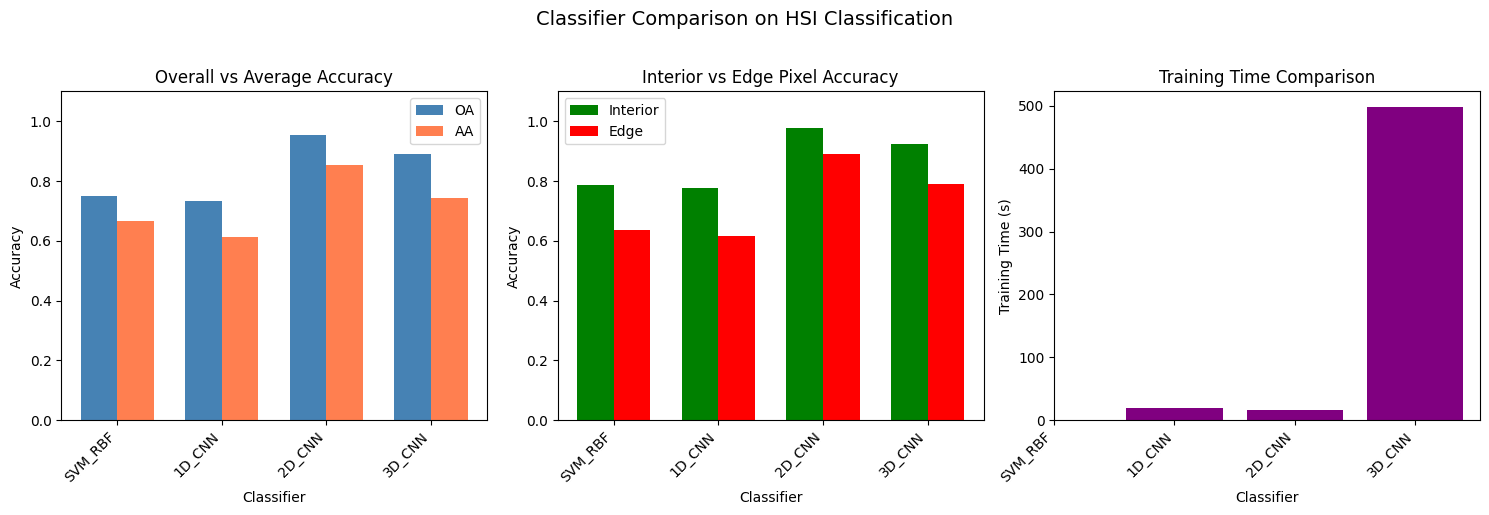

In [15]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = df_results['Model'].tolist()
x = np.arange(len(models))
width = 0.35

# Plot 1: Overall Accuracy
axes[0].bar(x, df_results['OA'], width, label='OA', color='steelblue')
axes[0].bar(x + width, df_results['AA'], width, label='AA', color='coral')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Overall vs Average Accuracy')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Plot 2: Edge vs Interior Accuracy
axes[1].bar(x - width/2, df_results['Interior_Acc'], width, label='Interior', color='green')
axes[1].bar(x + width/2, df_results['Edge_Acc'], width, label='Edge', color='red')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Interior vs Edge Pixel Accuracy')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1.1)

# Plot 3: Training Time
axes[2].bar(x, df_results['Train_Time_s'], color='purple')
axes[2].set_xlabel('Classifier')
axes[2].set_ylabel('Training Time (s)')
axes[2].set_title('Training Time Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45, ha='right')

plt.suptitle('Classifier Comparison on HSI Classification', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('classifier_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Find best model
best_model = df_results.loc[df_results['OA'].idxmax(), 'Model']
best_edge_model = df_results.loc[df_results['Edge_Acc'].idxmax(), 'Model']

print(f"\n★ Best Overall Accuracy: {best_model}")
print(f"★ Best Edge Pixel Accuracy: {best_edge_model}")


★ Best Overall Accuracy: 2D_CNN
★ Best Edge Pixel Accuracy: 2D_CNN
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 6. Thesis Conclusions

### Key Findings

1. **SVM vs CNN**: How do spectral-only methods compare to spatial-spectral methods?
2. **Edge Pixels**: Which architecture handles boundary pixels best?
3. **Efficiency**: Trade-off between accuracy and training time

### Recommendations for Thesis

- Use **SVM** as baseline for spectral-only classification
- Compare **3D-CNN** for joint spatial-spectral feature learning
- Report **edge pixel accuracy** as key metric for local similarity

In [18]:
# Save results
df_results.to_csv('classifier_comparison_results.csv', index=False)
print("\n✓ Results saved to classifier_comparison_results.csv")
print("\nView all experiments in MLflow: mlflow ui --port 5000")


✓ Results saved to classifier_comparison_results.csv

View all experiments in MLflow: mlflow ui --port 5000
